# Solid Waste Analysis
## Question

It is important for the City of Baltimore to provide services equitably to residents. A key performance indicator (KPI) of many city services is on time completion (completing work before the due date). Solid Waste would like to assess the performance of their services (SR Type), specifically Cleaning, Boarding, High Grass and Weeds (HGW), Dirty Streets, and Dirty Alleys. 


In [1]:
#Import Dependencies
import pandas as pd
import numpy as np 
import matplotlib as plt
from IPython.display import display, HTML

#This originally imported the Excel doc and saved it off as a pickle file for quick access.
"""import pandas as pd 
original_recs = pd.read_excel
(r'311_CSR_SW.xlsx')
original_recs.to_pickle('311_CSR_SW.pkl')
original_recs.head()"""

#Functions to init
def graph_hoods_by_overdue(df, name, sort_type='overdue'):
    overdue_by_hood = group_hoods(df)
    if sort_type == 'overdue':
        sorted_overdue = sort_by_overdue(overdue_by_hood)
        g = graph_hoods(sorted_overdue, name,"num","Neighborhoods, Ranked by % Overdue")
    elif sort_type == 'crime':
        sorted_overdue = sort_by_crime(overdue_by_hood)
        g = graph_hoods(sorted_overdue, name,"Crime Total","Neighborhoods, Ranked by Crime Total")
    return g

def group_hoods(df):
    neighborhood_groups = df.groupby("Neighborhood")
    overdue_by_hood = neighborhood_groups["Overdue"].apply(lambda x : x.sum()/len(x)).reset_index(name="Percent Overdue")
    overdue_count = neighborhood_groups["Overdue"].apply(lambda x: len(x)).reset_index(name = "Total")
    overdue_by_hood["Total Requests"] = overdue_count["Total"]
    return overdue_by_hood
    
def sort_by_overdue(df):
    sorted_overdue = df.sort_values(by="Percent Overdue")
    sorted_overdue["num"] = np.arange(0,len(df))
    sorted_overdue.drop(sorted_overdue.loc[sorted_overdue["Total Requests"]<36].index,inplace=True)
    return sorted_overdue

def sort_by_crime(df):
    crime_by_hood = pd.read_pickle(r'neighborhood_crime_data.pkl')
    df['Crime Total'] = df['Neighborhood'].apply(lambda x : crime_by_hood.loc[crime_by_hood['Neighborhood']==x]['Crime Total'])
    df.sort_values(by=['Crime Total'], inplace=True)
    df.drop(df.loc[df['Total Requests']<36].index, inplace=True)
    return df

def graph_hoods(df, name, xvalues, xlabel, ):
    g = df.plot(y="Percent Overdue", c="Total Requests", x=xvalues, kind="scatter", colormap='viridis', title=name, figsize= (5,4))
    g.set_xlabel(xlabel, fontsize=12)
    fig = g.get_figure()
    fig.savefig(name + 'percent late', bbox_inches = 'tight')
    return g


## Initialize Clean Records Dataframe

In [2]:
original_recs = pd.read_pickle(r"311_CSR_SW.pkl")

non_proactive_recs = original_recs.loc[original_recs["SR Type"].str.contains('Proactive')==False]
non_duplicate_recs = non_proactive_recs.loc[non_proactive_recs["SR Status"].str.contains('Duplicate')==False]

clean_recs = non_duplicate_recs[(non_duplicate_recs['Created Date'] > '2017-01-01 00:00:01') & (non_duplicate_recs['Created Date'] < '2019-12-31 23:59:59')]

clean_recs['Neighborhood'] = clean_recs['Neighborhood'].str.lower()

neighborhoods = clean_recs.groupby('Neighborhood').count()
neighborhoods['Neighborhood'] = neighborhoods.index

print(len(clean_recs))
clean_recs['geo_sw_quad'].isnull().sum()



241647


18256

## Import recent crime data from BPD
Link neighborhoods as key for data. 

### This strategy did not end up working because SW and BPD use very different nomeclature for neighborhoods.

In [3]:
"""crime_data = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')
crime_by_hood = crime_data.groupby('Neighborhood')
crime_by_hood = crime_by_hood.apply(lambda x : len(x)).reset_index(name='Crime Total')
crime_by_hood['Neighborhood']= crime_by_hood['Neighborhood'].str.lower()

def fix_hoods(x):
    match_hoods_dict = {
        'beechfield,westgate' : 'beechfield',
        'hopkins bayview' : 'bayview',
        'baltimore-linwood' : 'highlandtown',
        'care' : 'middle east',
        'chinquapin park-belvedere' : 'chinquapin park',
        'dundalk marine terminal':'saint helena',
        'edgewood' : 'allendale',
        'hamilton hills' : 'westfield',
        'christopher' : 'westfield',
        'glenham-belford':'glenham-belhar',
        'old goucher' : 'barclay',
        'sbic' : 'federal hill',
        'washington village' : 'washington village/pigtown',
        'wilhelm park' : 'morrell park',
        'woodring' : 'westfield',
        'wrenlane' : 'wilson park',
        'york-homeland' : 'woodbourne-mccabe'}
    #hoods_to_fix = ['bayview','baltimore-linwood','care', 'christopher','dundalk marine terminal','edgewood','glen''hamilton hills','old goucher','wilhelm park' 'wrenlane', 'york-homeland']
    if x in match_hoods_dict.keys():
        return match_hoods_dict[x]
    else:
        return x

clean_neighborhoods = []
for hood in crime_by_hood['Neighborhood']:
    matched = fix_hoods(hood)
    if matched == 'beechfield,westgate':
        print('boo')
    search = neighborhoods['Neighborhood'].loc[neighborhoods['Neighborhood'].str.contains(matched[:4])]
    if len(neighborhoods['Neighborhood'].loc[neighborhoods['Neighborhood']==matched]) == 1:
        clean_neighborhoods.append(matched)
    elif len(search) == 1:
        clean_neighborhoods.append(matched)
    elif len(search) < 1:
        input("No match for "+ matched)
    elif len(search) > 1:
        a =input(matched + " matches: " + ', '.join(search.tolist()) +' What do you want to use?')

crime_by_hood['Neighborhood'] = pd.Series(clean_neighborhoods)
grouped = crime_by_hood.groupby('Neighborhood')
crime_by_hood = grouped.sum()
crime_by_hood['Neighborhood']=crime_by_hood.index
display(crime_by_hood.loc[crime_by_hood['Neighborhood'].str[0]=='b'])
display(crime_by_hood)
crime_by_hood.to_pickle('neighborhood_crime_data.pkl')"""
"skip"

'skip'

### Question 1
How many of each type of service requests were created each year from 2017-2019?


In [4]:
service_groups = clean_recs.groupby(['SR Type'])
service_groups.size()

SR Type
SW-Boarding        24477
SW-Cleaning        37157
SW-Dirty Alley     72318
SW-Dirty Street    44723
SW-HGW             62972
dtype: int64

-1.3721720724893403
6.632517602513914


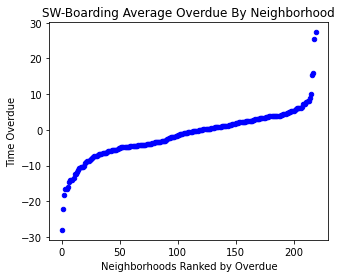

-36.45056957902805
50.444144243974705


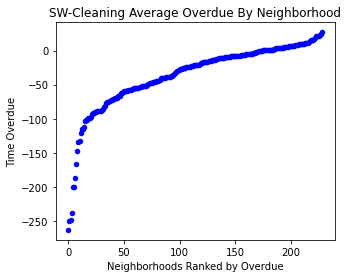

-26.71663595549232
31.59078070337494


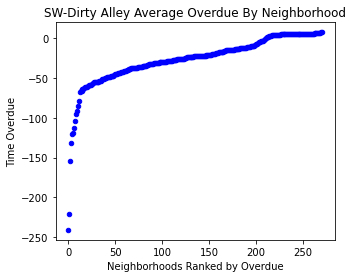

-3.544058872691564
14.281950440992604


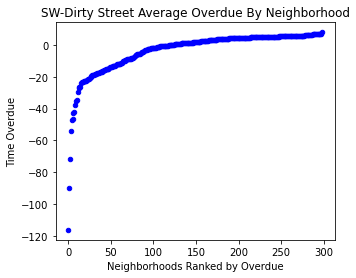

-63.83444387282625
60.91069334044726


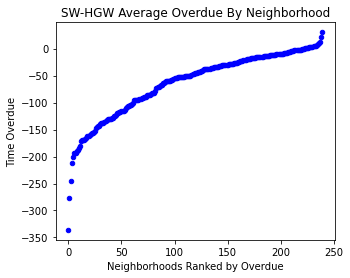

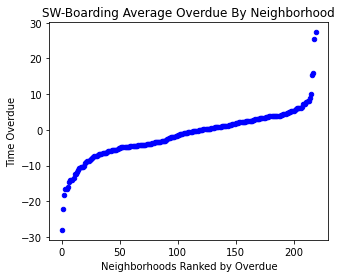

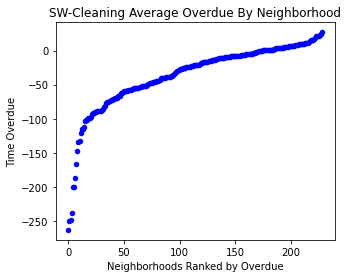

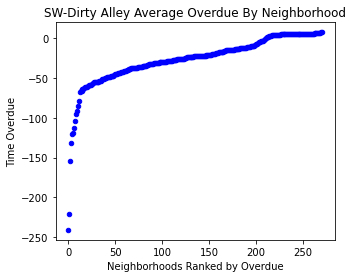

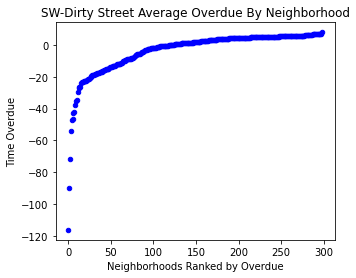

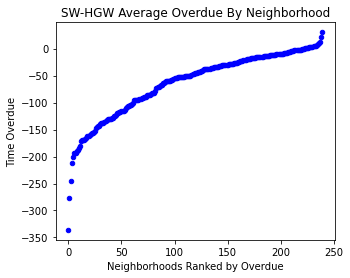

In [5]:
for group_s in service_groups:
    group = group_s[1]
    group['Time Overdue'] = group.apply(lambda x : (x['Due Date'] - x['Close Date']).days, axis = 1)
    group_by_neighborhood = group.groupby('Neighborhood')["Time Overdue"].mean().reset_index(name = 'Time Overdue')
    group_by_neighborhood= group_by_neighborhood.sort_values('Time Overdue')
    group_by_neighborhood['Neighborhoods Ranked by Overdue'] = np.arange(0, len(group_by_neighborhood))
    print(group_by_neighborhood['Time Overdue'].mean())
    print(group_by_neighborhood['Time Overdue'].std())
    g = group_by_neighborhood.plot(y="Time Overdue", x='Neighborhoods Ranked by Overdue', kind="scatter", color='blue', title=group_s[0]+" Average Overdue By Neighborhood", figsize= (5,4))
    graph = g.get_figure()
    graph.savefig(group_s[0] + "average overdue", bbox_inches = 'tight')
    
    display(graph)
    

### Question 2
What % of service requests were overdue each year? 


In [6]:
overdue_recs = clean_recs.copy()
overdue_recs['Overdue'] = clean_recs.apply(lambda x : x["Due Date"] < x["Close Date"], axis = 1)

years = [2017,2018,2019]



In [7]:
for year in years:
    total = len(overdue_recs[overdue_recs['Created Date'].dt.year == year])
    overdue = overdue_recs[overdue_recs['Created Date'].dt.year == year].copy()
    over = len(overdue[overdue['Overdue']==True])
    print('Total is '+str(total)+ 'and overdue is '+str(over))
    print('Percent in '+ str(year) + ' is ' + str(over/total))

Total is 80925and overdue is 21377
Percent in 2017 is 0.26415817114612294
Total is 87243and overdue is 29351
Percent in 2018 is 0.3364281375010029
Total is 73479and overdue is 37340
Percent in 2019 is 0.5081724029994965


### Question 3
How did % overdue change overtime?

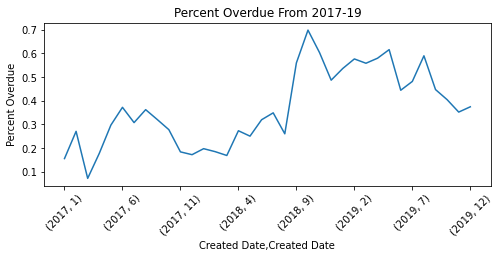

In [8]:
recs_and_overdue = clean_recs
recs_and_overdue["Overdue"] = (clean_recs["Due Date"] - clean_recs["Close Date"]) < pd.Timedelta(0)
by_complete_date_group = recs_and_overdue.groupby([recs_and_overdue["Created Date"].dt.year,recs_and_overdue["Created Date"].dt.month])

overdue_percent = by_complete_date_group["Overdue"].apply(lambda x : x.sum()/len(x))
graph = overdue_percent.plot(kind="line", rot=45, figsize=(8,3), title='Percent Overdue From 2017-19').set_ylabel("Percent Overdue")
fig = graph.get_figure()
fig.savefig('Percent Overdue Over Time.png', bbox_inches = 'tight')


### Question 4
Using the information calculated above and other information from the dataset, can you provide evidence to determine if service requests created in 2019 are being completed equitably across the city? 

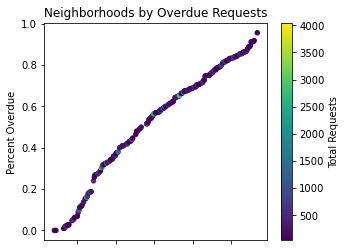

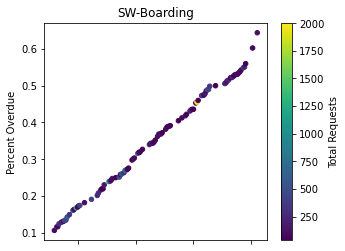

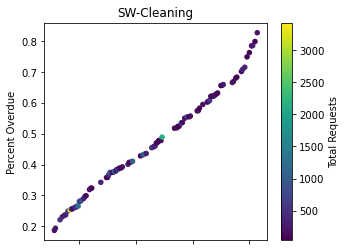

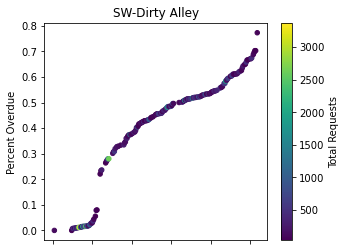

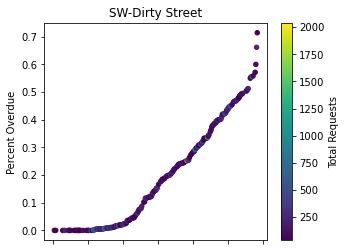

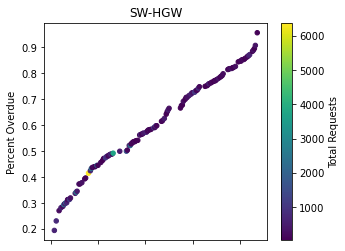

In [9]:
g = graph_hoods_by_overdue(clean_recs.loc[clean_recs["Created Date"].dt.year == 2019], "Neighborhoods by Overdue Requests")
fig = g.get_figure()
fig.savefig('Neighborhoods by Overdue Requests.png', bbox_inches = 'tight')
for group in service_groups:
    graph_hoods_by_overdue(group[1],group[0])


## Find connection between crime reports and service speed.
To link the data geographically, I cut the city up into 200 blocks.

In [11]:
sw_requests = clean_recs.copy()
bpd_requests = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', parse_dates=['CrimeDate'])
bpd_requests = bpd_requests[bpd_requests['CrimeDate'] > '2017-01-01']

def find_greatest_least(column):
    col = column.copy()
    col.sort_values(inplace=True)
    return (col.iloc[-1], col.iloc[0])

sw_requests = sw_requests[sw_requests['Latitude'] > 39].dropna()
bpd_requests = bpd_requests[bpd_requests['Latitude'] >39 & bpd_requests['Latitude'].notna() & bpd_requests['Longitude'].notna()]
print(len(bpd_requests))

sw_big_lat,sw_small_lat = find_greatest_least(sw_requests['Latitude'])
sw_big_lon,sw_small_lon = find_greatest_least(sw_requests['Longitude'])

big_lon = sw_big_lon
big_lat= sw_big_lat
small_lon = sw_small_lon
small_lat = sw_small_lat

print('big_lon', big_lon) 
print('big_lat', big_lat)
print('small_lon', small_lon) 
print('small_lat',small_lat)




176598
big_lon -76.5297751696803
big_lat 39.3719924255404
small_lon -76.7112772946237
small_lat 39.2004413570053


In [12]:
import math
def assign_grid(row):
    big_lon = -76.5297751696803
    big_lat =39.3719924255404
    small_lon= -76.7112772946237
    small_lat = 39.2004413570053
    grid_size = (10,20)
    x_size = (big_lon - small_lon)/grid_size[0]
    y_size = (big_lat - small_lat)/grid_size[1]
    lat = row['Latitude']
    lon = row['Longitude']
    x_loc = math.floor((lon - small_lon)/x_size)
    y_loc = math.floor((lat - small_lat)/y_size)
    return(pd.Series({"X Location": x_loc, "Y Location": y_loc}))

requests_with_region = sw_requests.copy()
requests_with_region[['X Location', 'Y Location']] = requests_with_region.apply(assign_grid, axis = 1)
reports_with_region = bpd_requests.copy()
reports_with_region[['X Location', 'Y Location']] = reports_with_region.apply(assign_grid, axis = 1)




In [13]:
requests_grouped = requests_with_region.groupby(by=['X Location', 'Y Location'])
reports_grouped = reports_with_region.groupby(by=['X Location','Y Location'])

def get_mean_overdue(df):
    df['Days Overdue'] = df.apply(lambda x : (x['Due Date'] - x['Close Date']).days, axis=1)
    return df['Days Overdue'].mean()

regional_overdue_mean = requests_grouped.apply(get_mean_overdue).reset_index(name='Mean Overdue')


In [14]:
regional_crime_totals = reports_grouped.apply(lambda x : len(x)).reset_index(name='Total')
scoped_crime= regional_crime_totals[regional_crime_totals['X Location']>=0]
scoped_crime = scoped_crime[scoped_crime['X Location']<21]
scoped_crime = scoped_crime[scoped_crime['Y Location']>-1]
scoped_crime = scoped_crime[scoped_crime['Y Location']<31]
scoped_crime.sort_values('Total')
regional_overdue_mean

,X Location,Y Location,Mean Overdue
0,0,8,-40.762712
1,0,9,-47.690867
2,0,10,-28.908297
3,0,11,-24.940594
4,0,12,-46.515625
...,...,...,...
150,9,16,-9.312500
151,9,17,-8.611111
152,9,18,-15.981043
153,9,19,-14.852273


,X Location,Y Location,Mean Overdue,Total,Total Crimes Reported
124,8,1,-95.000000,1.0,1.0
39,3,5,-78.303030,447.0,447.0
106,7,0,-74.500000,10.0,10.0
109,7,5,-73.000000,8.0,8.0
30,2,11,-72.558930,1957.0,1957.0
...,...,...,...,...,...
95,6,9,5.598969,2084.0,2084.0
125,8,7,5.600000,18.0,18.0
130,8,12,5.656489,752.0,752.0
126,8,8,5.888889,273.0,273.0


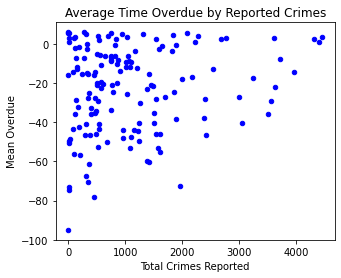

In [15]:
overdue_with_crime = pd.merge(left=regional_overdue_mean, right=scoped_crime, how='left', left_on=['X Location','Y Location'], right_on=['X Location','Y Location'])
overdue_with_crime['Total Crimes Reported'] = overdue_with_crime['Total'].fillna(0)
overdue_with_crime.sort_values('Total Crimes Reported')
overdue_with_crime = overdue_with_crime[overdue_with_crime['Mean Overdue']>-100]
display(overdue_with_crime.sort_values('Mean Overdue'))
overdue_with_crime=overdue_with_crime[overdue_with_crime['Total Crimes Reported']<5000]
g = overdue_with_crime.plot(y="Mean Overdue", x='Total Crimes Reported', kind="scatter", color='blue', title="Average Time Overdue by Reported Crimes", figsize= (5,4))
graph = g.get_figure()
graph.savefig('average overdue by reported crime.png', bbox_inches = 'tight')


In [16]:
overdue_with_crime.corr()

,X Location,Y Location,Mean Overdue,Total,Total Crimes Reported
X Location,1.000000,-0.163111,0.519940,-0.060630,-0.059015
Y Location,-0.163111,1.000000,0.330188,0.061088,0.063651
Mean Overdue,0.519940,0.330188,1.000000,0.169214,0.155644
Total,-0.060630,0.061088,0.169214,1.000000,1.000000
Total Crimes Reported,-0.059015,0.063651,0.155644,1.000000,1.000000
